## Brooklyn accessibility analysis


In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import contextily as ctx

sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (10, 5)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')

### 0. Load dataset

> **INFO**
> - `GEOID` is the unique identifier for every block
> 

In [55]:
df_blocks = gpd.read_file('data/bg_3_mo/bg_3_mo.shp')
df_blocks['trans_agg'] = df_blocks['num_bike'] + df_blocks['num_bus'] + df_blocks['num_bike']
df_blocks = df_blocks.rename(columns={'col_1': 'nycha'})

mapping_dict = {np.nan: False, 1: True}
df_blocks['nycha'] = df_blocks['nycha'].map(mapping_dict)

In [56]:
df_blocks.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,num_subs,num_bus,num_bike,trans_av,nycha,geometry,trans_agg
0,36,061,004400,0,360610044000,Block Group 0,G5030,S,0,465240,+40.7271982,-073.9667805,NaN,NaN,NaN,NaN,False,"MULTIPOLYGON (((-73.96225 40.72353, -73.96224 ...",NaN
1,36,047,006902,2,360470069022,Block Group 2,G5030,S,54968,0,+40.6849896,-073.9931832,NaN,NaN,1.0,1.0,False,"POLYGON ((-73.99458 40.68510, -73.99441 40.685...",NaN
2,36,047,006901,1,360470069011,Block Group 1,G5030,S,33186,0,+40.6856580,-073.9898060,1.0,NaN,1.0,2.0,False,"POLYGON ((-73.99090 40.68608, -73.99047 40.686...",NaN
3,36,047,006902,1,360470069021,Block Group 1,G5030,S,49677,0,+40.6840690,-073.9908755,NaN,NaN,NaN,NaN,False,"POLYGON ((-73.99219 40.68418, -73.99176 40.684...",NaN
4,36,047,033701,1,360470337011,Block Group 1,G5030,S,49555,0,+40.6700298,-073.9449277,NaN,1.0,2.0,3.0,False,"POLYGON ((-73.94771 40.66992, -73.94765 40.670...",5.0


In [57]:
df_blocks['nycha'].value_counts()

nycha
False    2076
True      117
Name: count, dtype: int64

### 1. Distance to transportation mode

### 1.1 How does the the distance to a public transportation mode in NYCHA blocks differ from the average block in Brooklyn?

In [59]:
aggregations = {
    'num_subs': ['std', 'mean', 'median', 'count'],
    'num_bus': ['std', 'mean', 'median', 'count'],
    'num_bike': ['std', 'mean', 'median', 'count']
}

result_table = df_blocks.groupby('nycha').agg(aggregations)

result_table

num_subs                          num_bus                         \
           std      mean median count       std      mean median count   
nycha                                                                    
False  0.28429  1.072368    1.0   152  1.001609  1.512524    1.0   519   
True   0.00000  1.000000    1.0     6  0.737899  1.653846    1.5    52   

       num_bike                         
            std      mean median count  
nycha                                   
False  0.841344  1.351293    1.0   464  
True   0.606478  1.333333    1.0    30

In [60]:
print(result_table.to_latex(index=False, formatters={"name": str.upper}, float_format="{:.2f}".format))  

\begin{tabular}{rrrrrrrrrrrr}
\toprule
\multicolumn{4}{r}{num_subs} & \multicolumn{4}{r}{num_bus} & \multicolumn{4}{r}{num_bike} \\
std & mean & median & count & std & mean & median & count & std & mean & median & count \\
\midrule
0.28 & 1.07 & 1.00 & 152 & 1.00 & 1.51 & 1.00 & 519 & 0.84 & 1.35 & 1.00 & 464 \\
0.00 & 1.00 & 1.00 & 6 & 0.74 & 1.65 & 1.50 & 52 & 0.61 & 1.33 & 1.00 & 30 \\
\bottomrule
\end{tabular}



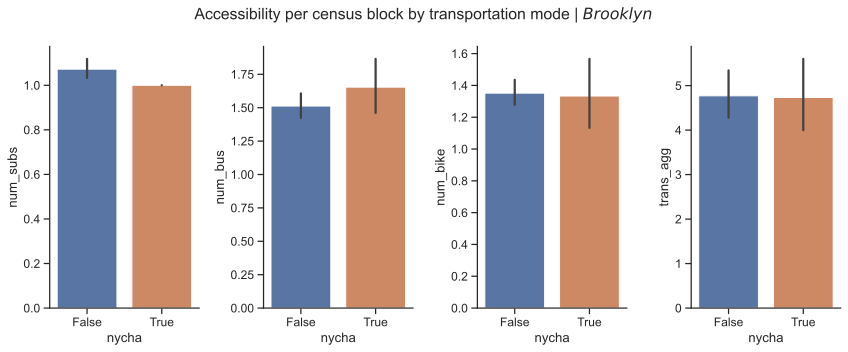

In [61]:
fig, axs = plt.subplots(1, 4, figsize=(12, 5))

fig.suptitle(r'Accessibility per census block by transportation mode | ${Brooklyn}$')

sns.barplot(df_blocks, y="num_subs",  x="nycha", ax=axs[0], hue="nycha", legend=False)
sns.barplot(df_blocks, y="num_bus",  x="nycha", ax=axs[1], hue="nycha", legend=False)
sns.barplot(df_blocks, y="num_bike", x="nycha", ax=axs[2], hue="nycha", legend=False)
sns.barplot(df_blocks, y="trans_agg",  x="nycha", ax=axs[3], hue="nycha", legend=False)

plt.tight_layout()
sns.despine()

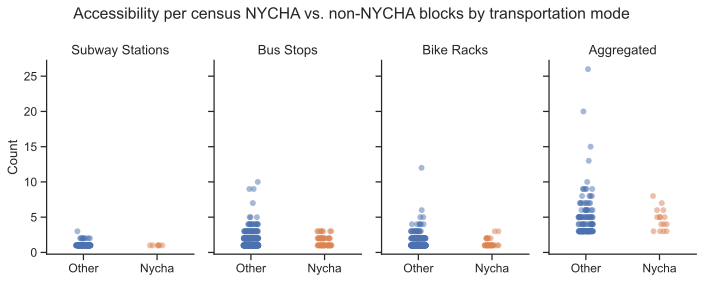

<Figure size 1000x500 with 0 Axes>

In [65]:
fig, axs = plt.subplots(1, 4, figsize=(10, 4), sharey=True)

fig.suptitle(r'Accessibility per census NYCHA vs. non-NYCHA blocks by transportation mode')

sns.stripplot(data=df_blocks, y="num_subs",  x="nycha", ax=axs[0], hue="nycha", dodge=False, size=6, alpha=0.5, legend=False)
sns.stripplot(data=df_blocks, y="num_bus",  x="nycha", ax=axs[1], hue="nycha", dodge=False, size=6, alpha=0.5, legend=False)
sns.stripplot(data=df_blocks, y="num_bike", x="nycha", ax=axs[2], hue="nycha", dodge=False, size=6, alpha=0.5, legend=False)
sns.stripplot(data=df_blocks, y="trans_agg",  x="nycha", ax=axs[3], hue="nycha", dodge=False, size=6, alpha=0.5, legend=False)

# Update x labels
for ax in axs:
    ax.set_xticklabels(['Other', 'Nycha'])

# Update y-axis label
for ax in axs:
    ax.set_ylabel('Count')

# Update titles
axs[0].set_title('Subway Stations')
axs[1].set_title('Bus Stops')
axs[2].set_title('Bike Racks')
axs[3].set_title('Aggregated')
axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[2].set_xlabel('')
axs[3].set_xlabel('')   

plt.tight_layout()
sns.despine()
plt.show()

plt.savefig('figures/accessibility_per_census_block_by_transportation_mode.png', dpi=200);

### 1.2 Make stacked bar chart with average number of stations per mode per block (NYCHA vs. non-NYCHA) *weighted by **population***

- Open Q: Where can we find this demographic data?

In [ ]:
#TODO

### 1.3 Make stacked bar chart with average number of stations per mode per block (NYCHA vs. non-NYCHA) *weighted by **area***

- Open Q: what is our crs? [link](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.area.html)

Create a bar graph displaying the number of stations per squared kilometer between 'NYCHA' and 'non-NYCHA' blocks. Steps:

- Calculate the total number of stations ('num_subs', 'num_bus', 'num_bike') for each block type ('NYCHA' and 'non-NYCHA').
- Calculate the total area for each block type ('NYCHA' and 'non-NYCHA').
- Divide the total number of stations by the total area for each block type to get the stations per squared kilometer.
- Plot a bar graph to display the stations per squared kilometer for both block types.

In [75]:
df_blocks.to_crs(epsg=3857, inplace=True)

In [76]:
# Get the area of a block
df_blocks['area'] = df_blocks['geometry'].area

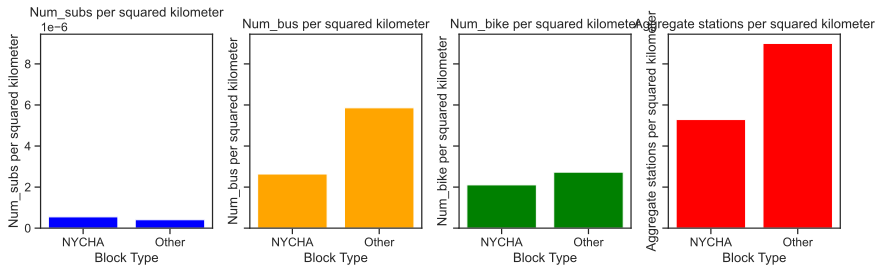

In [81]:
# Calculate stations and area for subway stations, bus stops, and Citibike racks for each block type
stations = ['num_subs', 'num_bus', 'num_bike']
block_types = ['nycha', ~df_blocks['nycha']]

colors = ['blue', 'orange', 'green']

fig, axs = plt.subplots(1, 4, figsize=(12, 4), sharey=True)

for i, station in enumerate(stations):
    station_counts = df_blocks.groupby('nycha')[station].sum()
    area = df_blocks.groupby('nycha')['area'].sum()
    stations_per_sq_km = (station_counts / area).tolist()

    axs[i].bar(['NYCHA', 'Other'], stations_per_sq_km, color=colors[i])
    axs[i].set_xlabel('Block Type')
    axs[i].set_ylabel(f'{station.capitalize()} per squared kilometer')
    axs[i].set_title(f'{station.capitalize()} per squared kilometer')

# Calculate aggregate of all stations
aggregate_stations = [sum(x) for x in zip(*[df_blocks.groupby('nycha')[station].sum() / df_blocks.groupby('nycha')['area'].sum() for station in stations])]
axs[3].bar(['NYCHA', 'Other'], aggregate_stations, color='red')
axs[3].set_xlabel('Block Type')
axs[3].set_ylabel('Aggregate stations per squared kilometer')
axs[3].set_title('Aggregate stations per squared kilometer')

plt.tight_layout()
plt.show()
